In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 500)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import re, string
import requests
from bs4 import BeautifulSoup
from itertools import groupby
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

from scipy import stats
from statsmodels.stats import weightstats as stests

from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

from Utils.UtilsViz import *
from Utils.DataUtils import *

In [3]:
data_path = "./data"
os.listdir(data_path)
train_set = pd.read_csv(pjoin(data_path, 'train.csv'))
test_set = pd.read_csv(pjoin(data_path, 'test.csv'))

In [4]:
train_set_ori = train_set.copy()

In [5]:
display(
    train_set.shape,
    train_set.head()
)

(7613, 5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
analyse_nans(train_set)

,id,keyword,location,text,target
total,0,61,2533,0,0
percentage,0,0.8,33.3,0,0
idx_list,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 38, 41, 43, 44, 45, 47, 60, 75, 80, 82, 85, 90, 92, 99, 110, 112, 116, 122, 123, 130, 131, 132, 135, 140, 147, 152, 156, 159, 164, 171, 174, 177, 182, 185, 187, 190, 196, 198, 202, 205, 206, 213, 214, 215, 219, 220, 222, 224, 225, 229, 231, 234, 236, 238, 240, 244, 245, 246, 250, 253, 256, 257, 261, 262, 267, 268, 274, 275, 279, ...]",[],[]


Much cleaner than msot datasets, to be fair.

Class distributions

In [7]:
train_set["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Fairly close. Can definitely work with this.

In [72]:
# Quick helper functions
def get_confusion_mat(y_true, y_pred, colnames=["Pred_0", "Pred_1"], index=["True_0", "True_1"]):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), columns=colnames, index=index)

#  Text cleaning

1. Lowercase text
1. Remove hashtags into separate columns
1. Remove special unrendered words
1. Remove hyperlinks
1. Remove non alphabets
1. remove stop words
1. Lemmatization

In [8]:
# Lowercase text
train_set["text"] = train_set["text"].apply(str.lower)
test_set["text"] = test_set["text"].apply(str.lower)

In [9]:
# Remove hashtags into separate columns
train_set["hashtags"] = train_set["text"].apply(lambda x: [w for w in x.split() if w[0]=="#"])
train_set["hashtags_text"] = train_set["hashtags"].apply(lambda x: [w[1:] for w in x ])
train_set["num_hashtags"] = train_set["hashtags"].apply(len)

test_set["hashtags"] = test_set["text"].apply(lambda x: [w for w in x.split() if w[0]=="#"])
test_set["hashtags_text"] = test_set["hashtags"].apply(lambda x: [w[1:] for w in x ])
test_set["num_hashtags"] = test_set["hashtags"].apply(len)

In [10]:
# Remove special unrendered words
# Example - & is represented as "&amp"
special_words = ["&amp;"]

def remove_specialwords(x):
    clean_str = [word for word in x.split(' ') if not any(spword in word for spword in special_words)]
    return ' '.join(clean_str)

train_set["text"] = train_set["text"].apply(remove_specialwords)
test_set["text"] = test_set["text"].apply(remove_specialwords)

In [11]:
# Remove hyperlinks
def remove_urls(x):
    clean_str = [word for word in x.split(' ') if "http" not in word]
    return ' '.join(clean_str)

train_set["text"] = train_set["text"].apply(remove_urls)
test_set["text"] = test_set["text"].apply(remove_urls)

In [12]:
# Remove non-alphabets
train_set["text"] = train_set["text"].apply(lambda x: re.sub('[^a-zA-Z ]', '', x))
test_set["text"] = test_set["text"].apply(lambda x: re.sub('[^a-zA-Z ]', '', x))

In [13]:
# Remove stop words
stop_words = text.ENGLISH_STOP_WORDS

def remove_stopwords(x):
    clean_str = [word for word in x.split(' ') if word not in stop_words]
    return ' '.join(clean_str)

train_set['text'] = train_set['text'].apply(remove_stopwords)
test_set['text'] = test_set['text'].apply(remove_stopwords)

In [14]:
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_words(x):
    clean_str = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in x.split(' ')]
    return ' '.join(clean_str)

train_set['text'] = train_set['text'].apply(lemmatize_words)
test_set['text'] = test_set['text'].apply(lemmatize_words)

### Tweet lenghts

How many characters are there in a tweet after cleaning the text?

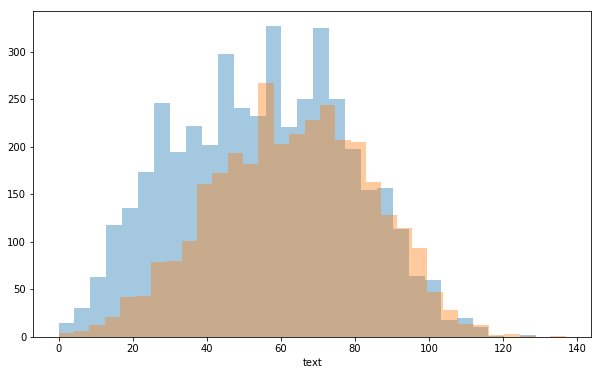

In [64]:
q0 = "target==0"
q1 = "target==1"
f, ax = plt.subplots(1,1,figsize=(10,6))
g = sns.distplot(a=train_set.query(q0)["text"].apply(len), ax=ax, kde=False)
g = sns.distplot(a=train_set.query(q1)["text"].apply(len), ax=ax, kde=False)

What about the number of words?

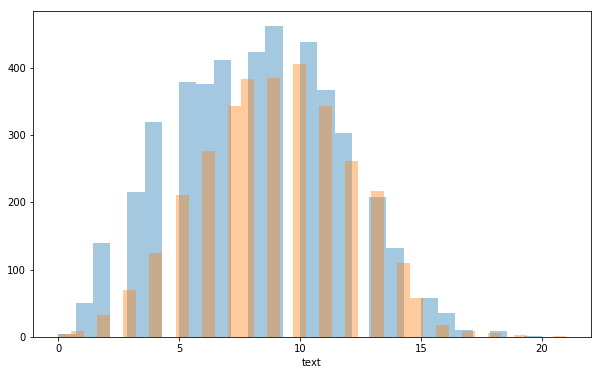

In [65]:
q0 = "target==0"
q1 = "target==1"

def get_numwords(v):
    return len(v.split())

f, ax = plt.subplots(1,1,figsize=(10,6))
g = sns.distplot(a=train_set.query(q0)["text"].apply(get_numwords), ax=ax, kde=False)
g = sns.distplot(a=train_set.query(q1)["text"].apply(get_numwords), ax=ax, kde=False)

Do the average word lenghts change?

[(2, 12)]

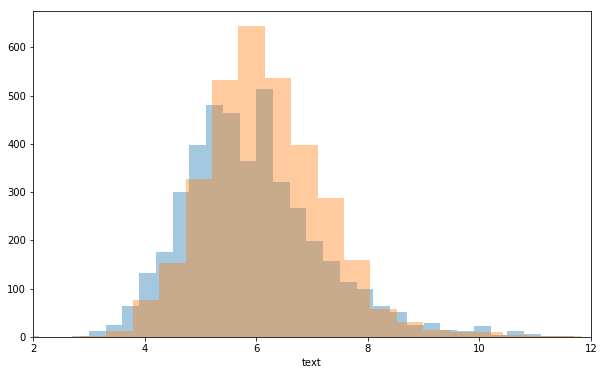

In [71]:
q0 = "target==0"
q1 = "target==1"

def get_avgwordlen(v):
    words = v.split()
    if len(words)==0:
        return 0
    return sum(map(len, words) ) / len(words)

f, ax = plt.subplots(1,1,figsize=(10,6))
g = sns.distplot(a=train_set.query(q0)["text"].apply(get_avgwordlen), ax=ax, kde=False)
g = sns.distplot(a=train_set.query(q1)["text"].apply(get_avgwordlen), ax=ax, kde=False)
g.set(xlim=(2,12))

<b>Observations</b>
- Non Disaster tweets have a tendency to be smaller than disaster tweets
- Disaster tweets also tend to have more number of words than non disaster tweets
- The average word lenghts of disaster tweets are slightly higher than non disaster tweets

### Wordclouds

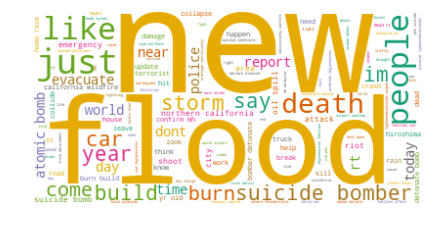

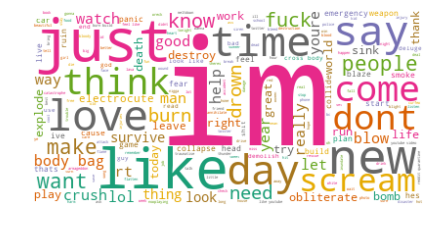

In [15]:
# Reset the output dimensions
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

def plot_wordcloud(text, wc, figsize=[7,7], title=""):
    plt.rcParams['figure.figsize'] = figsize
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    
q1 = "target==1"
t1 = ' '.join(train_set.query(q1)["text"].values)
plot_wordcloud(t1, wc)

q2 = "target==0"
t2 = ' '.join(train_set.query(q2)["text"].values)
plot_wordcloud(t2, wc)

We need to remove additional words that are polluting the wordcloud

# Filter out the rare words from the vocabulary

We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

In [16]:
cv_0 = CountVectorizer(stop_words=stop_words)
train_cv_0 = cv_0.fit_transform(train_set.query("target==0")["text"])
train_cv_0_dtm = pd.DataFrame(train_cv_0.toarray(), columns=cv_0.get_feature_names())
train_cv_0_dtm.index = train_set.query("target==0")["id"]
train_cv_0_dtm.head()

,aa,aaaa,aaceorg,aannnnd,aar,aaronthefm,ab,aba,abandon,abandonedpics,abbandoned,abbott,abbruchsimulator,abc,abceyewitness,abcnews,abe,aberdeen,aberdeenfanpage,aberdeenfc,abetter,ability,abject,ablaze,able,abomination,abortion,abortions,abovewould,abrancaballero,absolute,absolutely,absolutsumya,abstract,absurdly,abubaraa,abuse,abysmaljoiner,ac,acaciapenn,academia,acarewornheart,acc,accept,access,accident,accidentally,accidentalprophecy,accidently,accidents,...,yum,yumiko,yunita,yup,yuppies,yuvi,yyeso,zabadani,zacb,zach,zachlowenba,zachzaidman,zaire,zakbagans,zamtriossu,zar,zarharzar,zarry,zayn,zaynmalik,zenandemcfen,zenit,zeno,zepp,zero,zhejiang,zhenghxn,zicac,zimbabwe,zimmerman,zip,ziphimup,zippednews,zipper,zippoline,zmne,zodiac,zombie,zombiefunrun,zombies,zone,zonesthank,zonewolf,zoom,zouma,zrnf,zss,zumiez,zxathetis,zzzz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
cv_1 = CountVectorizer(stop_words=stop_words)
train_cv_1 = cv_1.fit_transform(train_set.query("target==1")["text"])
train_cv_1_dtm = pd.DataFrame(train_cv_1.toarray(), columns=cv_1.get_feature_names())
train_cv_1_dtm.index = train_set.query("target==1")["id"]
train_cv_1_dtm.head()

,aa,aaaaaaallll,aal,aan,aashiqui,aba,abandon,abbswinston,abbyairshow,abc,abcchicago,abcnews,abcnorio,abcs,abe,aberystwythshrewsbury,abes,abha,abia,ability,ablaze,able,ableg,abninfvet,aboard,abomb,abombed,abortion,abouts,abs,absence,absolute,absolutely,abstorm,absurd,abubaraa,abuse,ac,acc,accept,accepte,accident,accidentally,accidents,accidentwho,accionempresa,accord,account,accuracy,accuse,...,youd,yougov,youll,young,younger,youngheroesid,youre,yourstate,youth,youtube,youve,ypg,ypres,yr,yrs,yug,yugvani,yyc,yycfringe,yycstorm,yycwalks,yycweather,yygb,yyj,yzf,zaatari,zaibatsunews,zakbagans,zakuun,zaman,zayn,zaynmaiikist,zeal,zehrs,zergele,zimmer,zimpapersviews,zionism,zionist,zionists,zippednews,ziuw,zkesk,zojadelin,zomatoaus,zombie,zone,zotar,zourryart,zurich
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
train_cv_0_dtm_t = train_cv_0_dtm.transpose()
train_cv_1_dtm_t = train_cv_1_dtm.transpose()

What are the most common words?

In [19]:
def get_top_words(df, min_freq=1):
    df["total_freq"] = df.sum(axis=1)
    q = "total_freq>="+str(MIN_FREQ)
    return df.query(q)[["total_freq"]].sort_values(by="total_freq", ascending=False)

MIN_FREQ = 7
t0_common = get_top_words(train_cv_0_dtm_t, min_freq=MIN_FREQ)
t1_common = get_top_words(train_cv_1_dtm_t, min_freq=MIN_FREQ)

In [20]:
display(
    t0_common.shape,
    t1_common.shape
)

(1005, 1)

(898, 1)

What words occur in both in the top 50?

In [21]:
common_words = find_common_elems([list(t0_common.head(100).index), list(t1_common.head(100).index)])
common_words

['emergency',
 'live',
 'time',
 'look',
 'bomb',
 'crash',
 'war',
 'plan',
 'news',
 'video',
 'work',
 'dont',
 'build',
 'watch',
 'flood',
 'new',
 'say',
 'im',
 'attack',
 'burn',
 'service',
 'world',
 'rt',
 'people',
 'just',
 'come',
 'fear',
 'collapse',
 'cause',
 'today',
 'man',
 'like']

In [22]:
t0_common.head(50)

id,total_freq
like,292
im,245
just,232
new,170
dont,152
body,117
bag,110
come,109
love,109
say,106


Let's add these to the stop words

In [23]:
stop_words = stop_words.union(set(common_words))

Now we'll recreate our word clouds

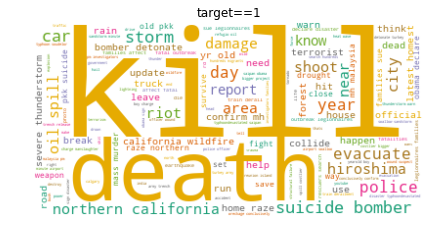

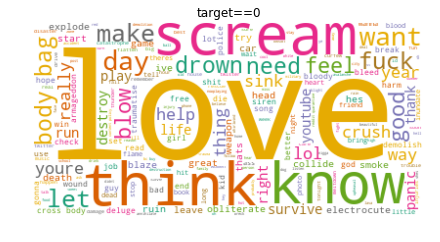

In [24]:
# Reset the output dimensions
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

def plot_wordcloud(text, wc, figsize=[7,7], title=""):
    plt.rcParams['figure.figsize'] = figsize
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    
q1 = "target==1"
t1 = ' '.join(train_set.query(q1)["text"].values)
plot_wordcloud(t1, wc, title=q1)

q2 = "target==0"
t2 = ' '.join(train_set.query(q2)["text"].values)
plot_wordcloud(t2, wc, title=q2)

Is there a sentiment polarity difference in the dataset?

In [25]:
sen_pol = lambda x: (np.round(TextBlob(x).sentiment.polarity,2), 
                     np.round(TextBlob(x).sentiment.subjectivity))
train_set["polarity_subjectivity"] = train_set["text"].apply(func=sen_pol)
train_set["polarity"] = train_set["polarity_subjectivity"].apply(lambda x: x[0])
train_set["subjectivity"] = train_set["polarity_subjectivity"].apply(lambda x: x[1])
train_set.drop("polarity_subjectivity", axis=1, inplace=True)


test_set["polarity_subjectivity"] = test_set["text"].apply(func=sen_pol)
test_set["polarity"] = test_set["polarity_subjectivity"].apply(lambda x: x[0])
test_set["subjectivity"] = test_set["polarity_subjectivity"].apply(lambda x: x[1])
test_set.drop("polarity_subjectivity", axis=1, inplace=True)

train_set.head()

,id,keyword,location,text,target,hashtags,hashtags_text,num_hashtags,polarity,subjectivity
0,1,NaN,NaN,deeds reason earthquake allah forgive,1,[#earthquake],[earthquake],1,0.0,0.0
1,4,NaN,NaN,forest near la ronge sask canada,1,[],[],0,0.1,0.0
2,5,NaN,NaN,residents ask shelter place notify officer evacuation shelter place order expect,1,[],[],0,0.0,0.0
3,6,NaN,NaN,people receive wildfires evacuation order california,1,[#wildfires],[wildfires],1,0.0,0.0
4,7,NaN,NaN,just get send photo ruby alaska smoke wildfires pour school,1,"[#alaska, #wildfires]","[alaska, wildfires]",2,0.0,0.0


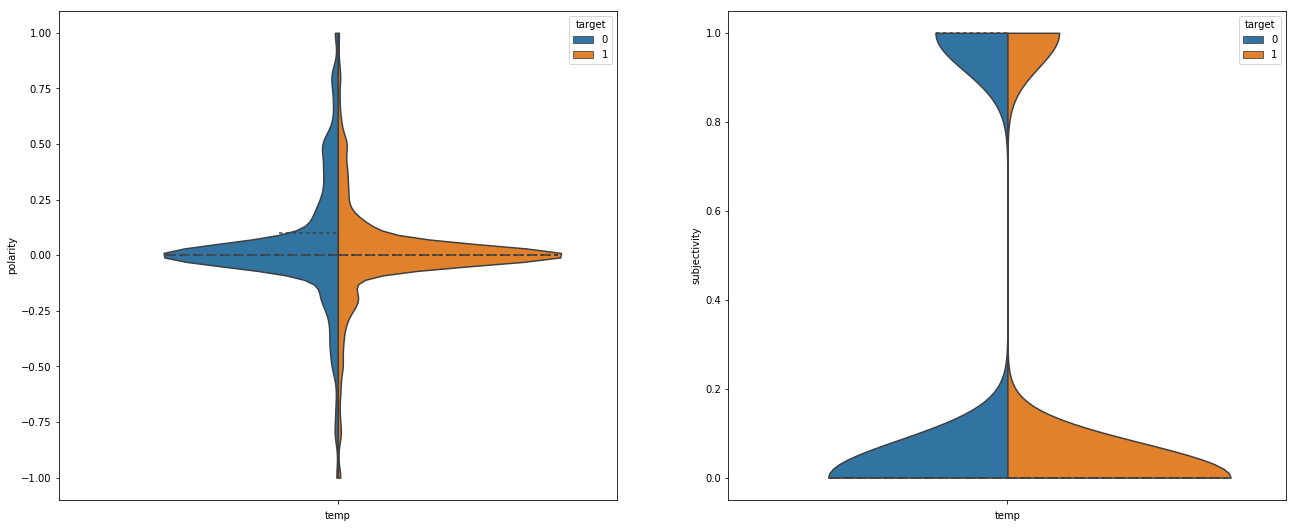

In [26]:
f, ax = plt.subplots(1,2,figsize=(22,9))
# Bug? https://stackoverflow.com/questions/33745746/split-violinplot-in-seaborn-with-hue-parameter
train_set["temp"] = ""
g = sns.violinplot(y="polarity", x="temp", hue="target", data=train_set, ax=ax[0], inner='quartile', cut=0, split=True)
g = sns.violinplot(y="subjectivity", x="temp", hue="target", data=train_set, ax=ax[1], inner='quartile', cut=0, split=True)

train_set.drop("temp", inplace=True, axis=1)

Can we statistically distinguish the two?

In [27]:
ztest ,pval = stests.ztest(x1=train_set.query("target==0")['polarity'], 
                           x2=train_set.query("target==1")['polarity'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

1.190407604983351e-12
We reject null hypothesis


In [28]:
ztest ,pval = stests.ztest(x1=train_set.query("target==0")['subjectivity'], 
                           x2=train_set.query("target==1")['subjectivity'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

1.7407598879184746e-23
We reject null hypothesis


Both features may be useful in adding to the predictive power.

---------

### What about LDA Topic modeling?

In [29]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

def plot_lda(df, colname, num_topics=3, min_df=0.05, max_df=0.8, max_iter=100):
    # Make the vectorizer and vectorize the data
    
    # NOTE : Use previous count vectorized functions
    vectorizer = CountVectorizer(min_df=min_df,  # if a word exists in less than 10% documents, ignore them
                                 max_df=max_df,  # Avoid words that come in over 90% of all documents
                                 stop_words=stop_words, 
                                 lowercase=True)
    data_vectorized = vectorizer.fit_transform(df[colname])

    # Build a Latent Dirichlet Allocation Model
    lda_model = LatentDirichletAllocation(n_components=num_topics, 
                                          max_iter=max_iter,
                                          learning_method='online')
    lda_Z = lda_model.fit_transform(data_vectorized)
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

In [30]:
# panel_0 = plot_lda(train_set.query("target==0"), colname="text", num_topics=2, min_df=0, max_iter=10)
# panel_1 = plot_lda(train_set.query("target==1"), colname="text", num_topics=2, min_df=0, max_iter=20)

LDA takes waay too long in my laptop. I'm going to not do it.

--------------

# Hashtags

What are the most common hashtags?

(1153, 2)

(1003, 2)

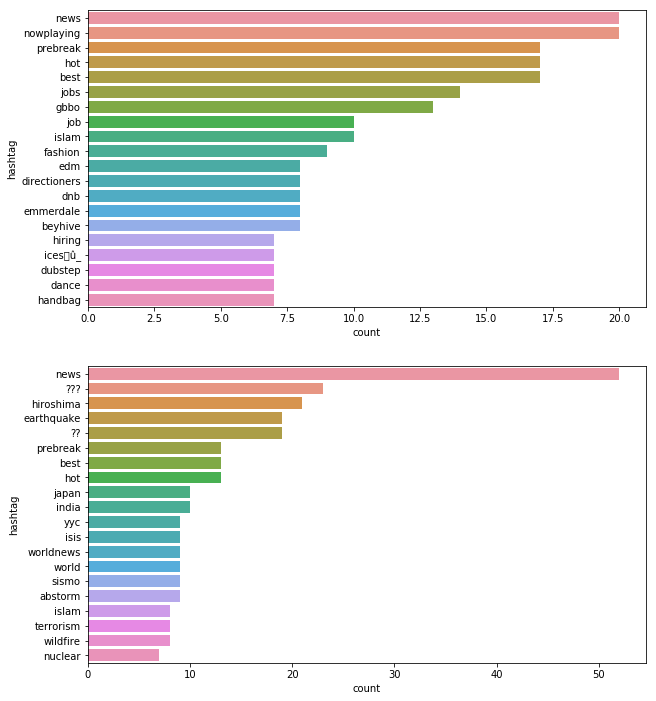

In [31]:
q0 = "target==0"
q1 = "target==1"

all_t0_hashtags = np.asarray([item for sublist in train_set.query(q0)["hashtags_text"].values for item in sublist])
all_t1_hashtags = np.asarray([item for sublist in train_set.query(q1)["hashtags_text"].values for item in sublist])
tag0, count0 = np.unique(all_t0_hashtags, return_counts=True)
tag1, count1 = np.unique(all_t1_hashtags, return_counts=True)

hashtag_t0_df = pd.DataFrame(list(zip(tag0, count0)))
hashtag_t1_df = pd.DataFrame(list(zip(tag1, count1)))

hashtag_t0_df.columns = ["hashtag", "count"]
hashtag_t1_df.columns = ["hashtag", "count"]

hashtag_t0_df.sort_values("count", ascending=False, inplace=True)
hashtag_t1_df.sort_values("count", ascending=False, inplace=True)

display(
    hashtag_t0_df.shape,
#     hashtag_t0_df.head(20),
    hashtag_t1_df.shape,
#     hashtag_t1_df.head(20)
)

f, ax = plt.subplots(2,1, figsize=(10,12))
g = sns.barplot(x="count", y="hashtag", data=hashtag_t0_df.head(20), ax=ax[0])
g = sns.barplot(x="count", y="hashtag", data=hashtag_t1_df.head(20), ax=ax[1])

How many hashtags do we have for tweets (greater than 0)

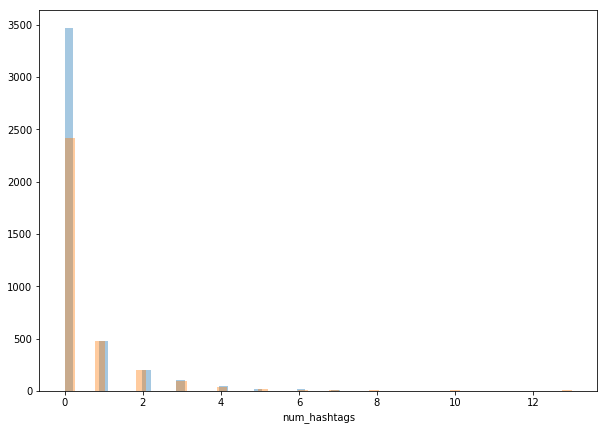

In [32]:
f, ax = plt.subplots(1,1,figsize=(10,7))
g = sns.distplot(a=train_set.query("(target==0)&(num_hashtags>=0)")["num_hashtags"], ax=ax, kde=False)
g = sns.distplot(a=train_set.query("(target==1)&(num_hashtags>=0)")["num_hashtags"], ax=ax, kde=False)

In [33]:
ztest ,pval = stests.ztest(x1=train_set.query("(target==0)&(num_hashtags>0)")['num_hashtags'], 
                           x2=train_set.query("(target==1)&(num_hashtags>0)")['num_hashtags'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

0.6550477883131247
We fail to reject the null hypothesis


It would seem that the number of hashtags may not necessarily add predictive power to the model.

# Sentiment analysis using predictive modeling

First things first, split the train_set into training and validation data sets

In [34]:
train_data, val_data = train_test_split(train_set, test_size=0.3)

Before we train any advanced models, let's have a look at words that likely identify classes.

The idea of this very simple words polarity analysis based on logistic regression coefficients was suggested by [SerMakarevich](https://www.kaggle.com/sermakarevich/words-polarity-based-on-lr-weights). It consists of two steps:

- create tf-idf features for words from train data set comments;
- fit logistic regression model taking these features as regressors and class labels as target variable.

The word regression coefficient can be considered as a polarity measure for given target type.

In [35]:
tfidf = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.9)
X = tfidf.fit_transform(train_data["text"])

In [37]:
logit = LogisticRegression()
logit.fit(X, train_data['target'].values)

train_ylabels = logit.predict(X)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data['target'].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data['target'].values.ravel(), train_ylabels))


X_val = tfidf.transform(val_data["text"])
val_ylabels = logit.predict(X_val)


print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3017
           1       0.90      0.75      0.82      2312

    accuracy                           0.85      5329
   macro avg       0.86      0.84      0.85      5329
weighted avg       0.86      0.85      0.85      5329

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,2814,203
True_1,578,1734


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1325
           1       0.79      0.69      0.73       959

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1152,173
True_1,302,657


A training accuracy of 0.82 and validation accuracy of 0.8.

A fairly good baseline model.

In [38]:
polarity = pd.DataFrame.from_dict(tfidf.vocabulary_,orient='index')\
                                                    .sort_values(0)
polarity['coef'] = logit.coef_[0]

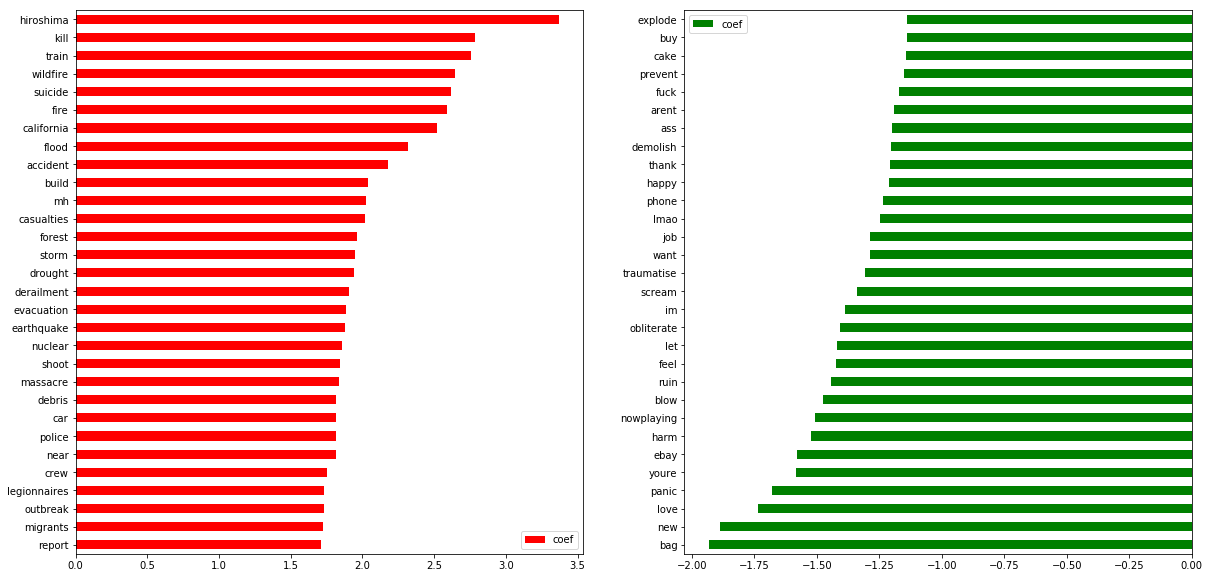

In [47]:
from matplotlib import pyplot as plt
polarity.sort_values('coef',inplace=True)
plt.figure(figsize=(20, 10))
ax = plt.subplot(1,2,1)
polarity[['coef']].tail(30).plot(kind='barh', color='red', ax=ax)
ax = plt.subplot(1,2,2)
polarity[['coef']].head(30).plot(kind='barh', color='green', ax=ax)

### Do Bi and Tri grams increase context here?

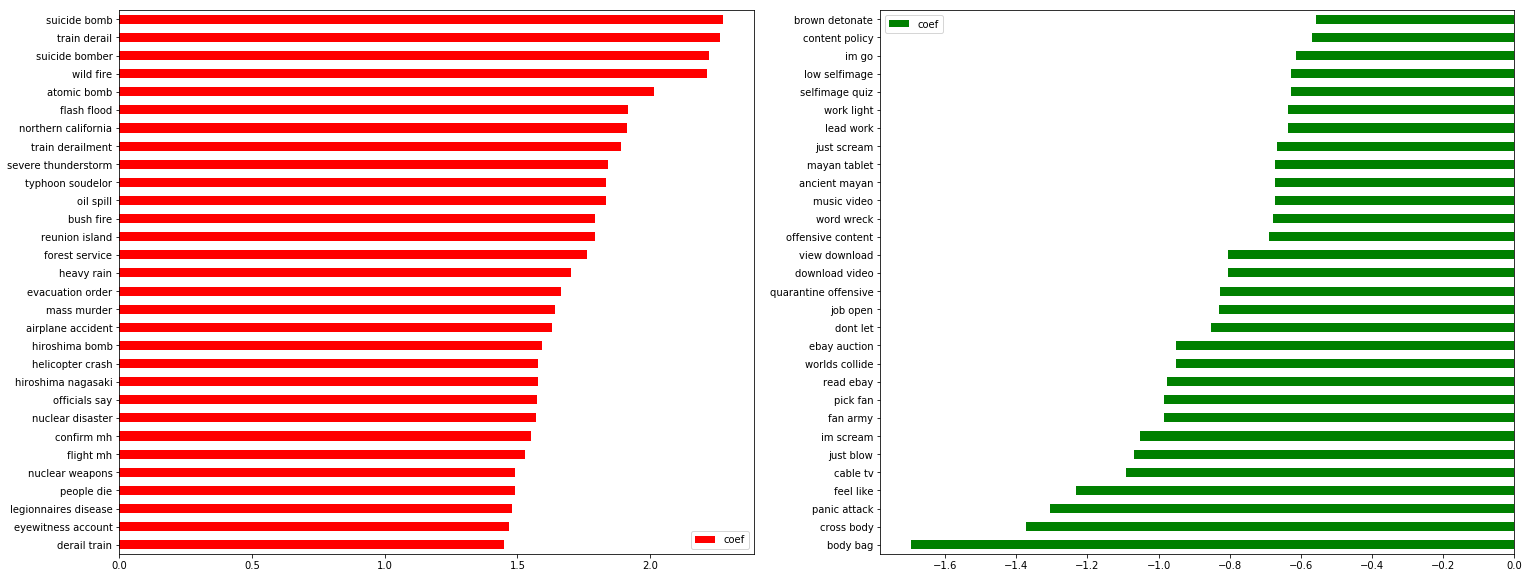

In [77]:
tfidf = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.9, ngram_range=(2,2))
X = tfidf.fit_transform(train_data["text"])

logit = LogisticRegression()
logit.fit(X, train_data['target'].values)
polarity = pd.DataFrame.from_dict(tfidf.vocabulary_,orient='index')\
                                                    .sort_values(0)
polarity['coef'] = logit.coef_[0]

from matplotlib import pyplot as plt
polarity.sort_values('coef',inplace=True)
plt.figure(figsize=(25, 10))
ax = plt.subplot(1,2,1)
polarity[['coef']].tail(30).plot(kind='barh', color='red', ax=ax)
ax = plt.subplot(1,2,2)
polarity[['coef']].head(30).plot(kind='barh', color='green', ax=ax)

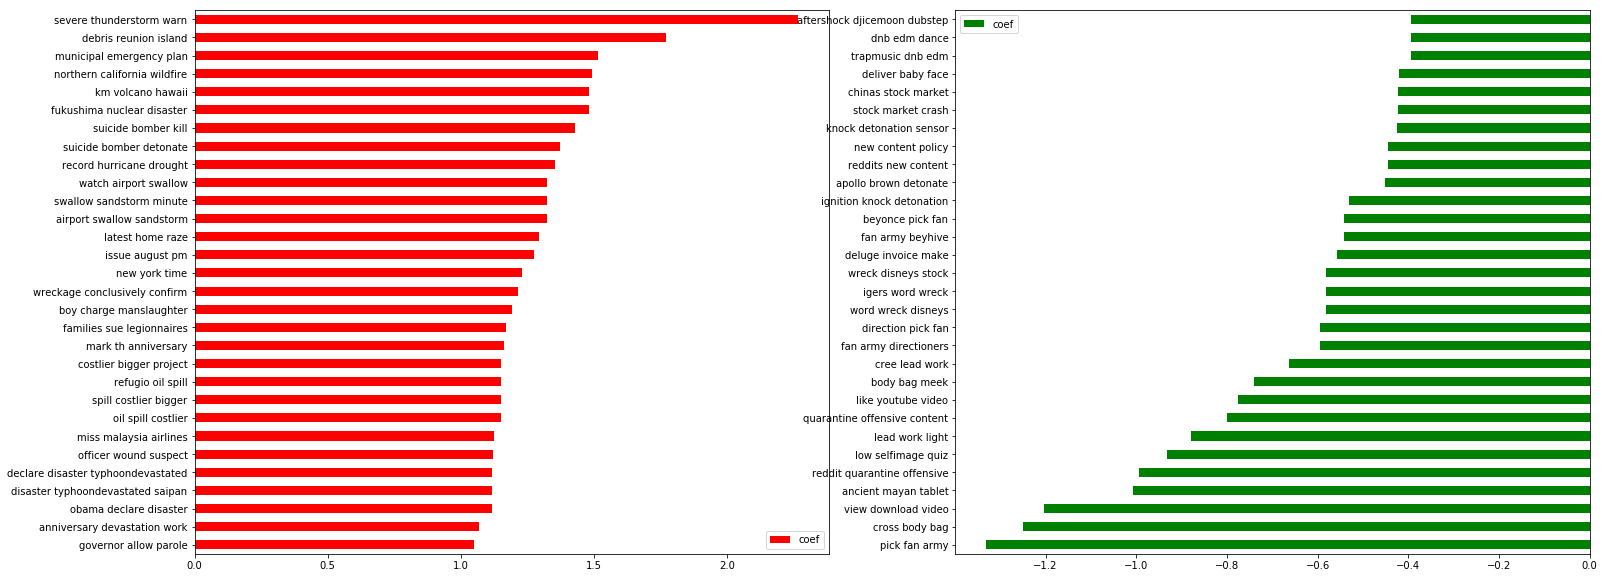

In [76]:
tfidf = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.9, ngram_range=(3,3))
X = tfidf.fit_transform(train_data["text"])

logit = LogisticRegression()
logit.fit(X, train_data['target'].values)
polarity = pd.DataFrame.from_dict(tfidf.vocabulary_,orient='index')\
                                                    .sort_values(0)
polarity['coef'] = logit.coef_[0]

from matplotlib import pyplot as plt
polarity.sort_values('coef',inplace=True)
plt.figure(figsize=(25, 10))
ax = plt.subplot(1,2,1)
polarity[['coef']].tail(30).plot(kind='barh', color='red', ax=ax)
ax = plt.subplot(1,2,2)
polarity[['coef']].head(30).plot(kind='barh', color='green', ax=ax)

-----------

In [98]:
# Save the files to disk
train_data.to_csv("./train_cleaned.csv", index=False)
val_data.to_csv("./val_cleaned.csv", index=False)
test_set.to_csv("./test_cleaned.csv", index=False)

-------

# Test set

In [46]:
# baseline model - TFIDF + LogReg
X_test = tfidf.transform(test_set["text"])
test_ylabels = logit.predict(X_test)

In [43]:
sample_sub=pd.read_csv('./data/sample_submission.csv')
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':test_ylabels})
sub.to_csv('submission.csv',index=False)